In [17]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path  

# visualization
import matplotlib.pyplot as plt
import seaborn as sns 

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Algorithms
from prophet import Prophet

# Model performance evaluation
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

In [2]:
def pullData(filename,date_col):
    filepath = Path(filename)
    df = pd.read_csv(filepath) 
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    return df

In [3]:
dsbysite = pullData('..\AggregatedData\ZTE_CallAccess_FDD.csv','datetime')
dsbysite.head(5)

,Number of Successful Mt-Access RRC Establishment(times),Number of Mo-Data RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to ENB Admission Failure(times),Number of Mo-Signalling RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to Timeout(times),Number of mo-VoiceCall RRC Establishment Failure due to Other Reason(times),Number of mo-VoiceCall RRC Establishment Failure due to ENB Admission Failure(times),Number of Mt-Access RRC Establishment Failure due to Timeout(times),Number of Mo-Signalling RRC Establishment Failure due to Timeout(times),Number of Successful Mo-Signalling RRC Establishment(times),...,Number of Cell DRB Admission Failure due to PHY Resource Allocated Failure(times),Number of Cell Admission Failure due to Service Cell Other Parameters Modification(times),Number of Cell Admission Failure due to Target PLMN selected Failure(times),Number of Cell Admission Failure due to RRC Connection Number License Prohibit(times),Number of Cell Admission Failure due to E-RAB Number License Prohibit(times),Cell Service Time(s),Maximum Number of RRC Connection User(unit),Number of E-RAB HO Incoming Admission Request(unit),Number of E-RAB(QCI7) HO Incoming Admission Request(unit),SiteCode
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-31 00:00:00,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.125,0.208333,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,6.083333,16.250000,1.916667,PAF003
2023-01-31 01:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,5.041667,10.041667,1.583333,PAF003
2023-01-31 02:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,5.000000,10.000000,1.958333,PAF003
2023-01-31 03:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,4.458333,7.166667,1.458333,PAF003
2023-01-31 04:00:00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.041667,0.0,...,0.0,0.0,0.0,0.0,0.0,900.0,4.500000,7.250000,1.666667,PAF003


### Basic Functions for Data Preparations
-  Feature Selction
-  Missing Values Filling
-  Data Normalization
-  Seasonal decomposition - rollingAvg

In [4]:
def remove_high_corr_features(df,threshold_in, plotCorrelationMatrix = False):
    # calculate the correlation matrix
    corr_matrix = df.corr()

    # create a mask to ignore the diagonal elements of the correlation matrix
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask)] = True
    
    # plot the correlation matrix
    if(plotCorrelationMatrix == True):
        sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm')

    # select features with high correlation coefficients
    high_corr_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold_in:
                colname = corr_matrix.columns[i]
                high_corr_features.add(colname)
            
            
    # drop the highly correlated features from the dataset
    return df.drop(high_corr_features, axis=1)


# Normalized Values with StandardScaler or MinMaxScaler
# Use the VarianceThreshold feature_selection to remove all low-variance features.
def remove_low_variance_features(df,threshold_in):
    #print(.140 * (1 - .140))
    df  = df.copy()
    features = df.columns
    
    sel = VarianceThreshold(threshold=threshold_in) 
    x = sel.fit_transform(df)
    
    # Get the indices of the selected features
    selected_indices = sel.get_support(indices=True)
        
    # Get the names of the selected features
    selected_features = df.columns[selected_indices]
   
    #low_variance_features = intersection(features,selected_features)
    low_variance_features = set(features)-set(selected_features)
    
    #print('{} - {}'.format(len(features),len(selected_features)))
    #print(len(low_variance_features))
    
    # drop the highly correlated features from the dataset
    return df.drop(low_variance_features, axis=1)


def fillNa(df,rolling_window):
    df = df.copy()
   
    # Show the rows with NAN values
    nan_rows = df[df.isnull().any(axis=1)]
    
    while(nan_rows.shape[0] > 0):
        # Use transform to fill null values with the rolling mean of the corresponding group
        df = df.transform(lambda x: x.fillna(x.rolling(window=rolling_window, min_periods=1).mean()))
        nan_rows = df[df.isnull().any(axis=1)]
           
        # Fill null values with zeros
        #dset = dset.fillna(-999)
        # dset = dset.dropna()
    return df

def normalizedValues(df,scaler):
    df = df.copy()
    #scaler = StandardScaler()
    #scaler = MinMaxScaler((0, 1))
    # Min Max Scaler
    ts = scaler.fit_transform(df)

    lables = df.columns
    for i in range(len(lables)):
        df[lables[i]] = ts.T[i]
    
    return df

def rollingAvg(df,rolling_window):
    df = df.copy()
    df = df.rolling(window=rolling_window).mean()
    #df = df.transform(lambda x: x.fillna(x.rolling(window=rolling_window, min_periods=1).mean()))
    df = df.dropna()
    return df  

# Check for missing values
def getMissingValues(df):
    columns_missing_values = {}
    for c in df.columns:
        msv = df[df[c].isna()| df[c].eq(' ')].shape[0]
        if msv > 0:
            columns_missing_values[c] = (msv,msv/df.shape[0]*100)
    return columns_missing_values

In [5]:
def splitData(df,train_pct = 0.7):
    
    # get the unique dates from the index
    unique_days = pd.Series(df.index.date).unique()
    
    # calculate the number of rows for the training set
    train_size = int(len(unique_days) * train_pct)
    print(train_size)
        
    # calculate the end time of the training set
    train_end_time = df.index.min() + pd.Timedelta(train_size, unit="d")
    print(train_end_time)
    
    # separate the dataframe into training and testing sets
    train_df = df.loc[:train_end_time]
    test_df = df.loc[train_end_time + pd.Timedelta(hours=1):]
    
    return train_df,test_df

### Data Preprocessing

In [6]:
dfdata = dsbysite.loc[dsbysite['SiteCode'] == 'LIM003'].copy() #LIM090 LIM003 PAF024
dfdata = dfdata.drop('SiteCode', axis=1)
dfdata = fillNa(dfdata,24)

dfdata = remove_low_variance_features(dfdata,0.05)
print(dfdata.shape)
dfdata = remove_high_corr_features(dfdata,0.999)
print(dfdata.shape)

(1176, 64)
(1176, 46)


In [16]:
dfdata = normalizedValues(dfdata,StandardScaler()) # MinMaxScaler(feature_range=(0, 1)))
train_data,test_data = splitData(dfdata,0.7)

34
2023-03-06 00:00:00


# Prophet
Prophet is a time series forecasting model developed by Facebook that can be used to identify outliers in time series data..

## Detecting Past Anomalies:

00:24:21 - cmdstanpy - INFO - Chain [1] start processing


Number of Successful Context Modify (times)


00:24:21 - cmdstanpy - INFO - Chain [1] done processing


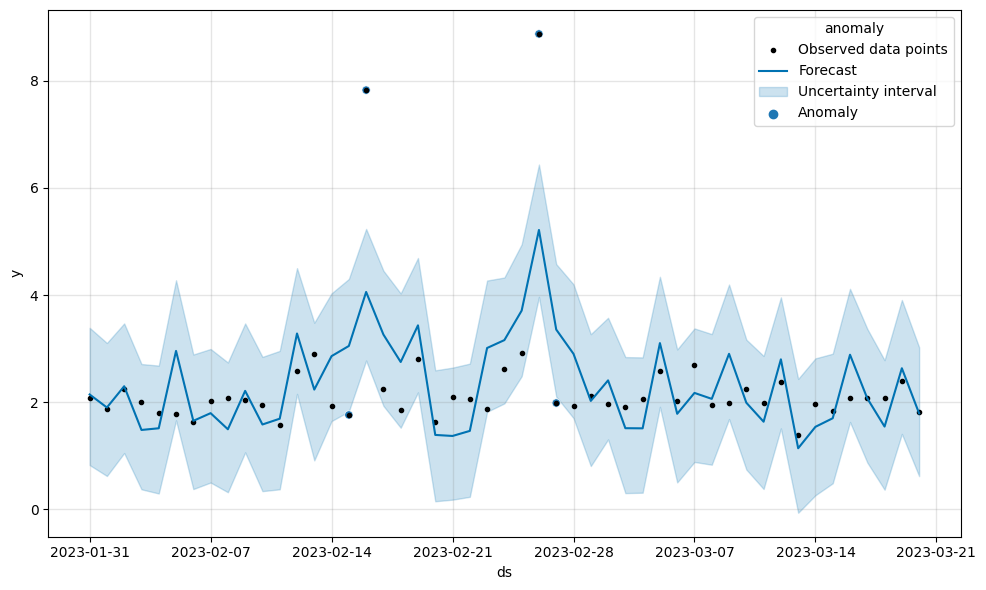

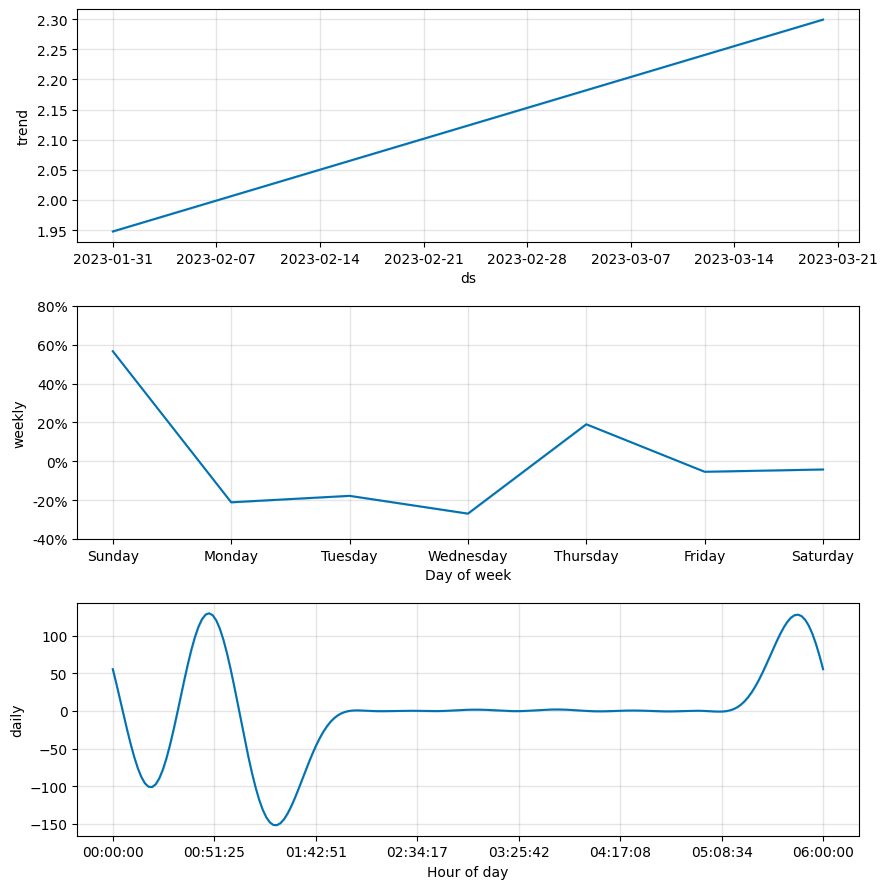

In [31]:
def getOutlier(df, column_index):

    # Add seasonality
    model = Prophet(seasonality_mode='multiplicative', growth = 'linear')
    #,daily_seasonality=True, weekly_seasonality=True)
  #          seasonality_mode='multiplicative')
    #interval_width=0.99)
    #                #,yearly_seasonality=True, weekly_seasonality=True)
    #    #)
    model.add_seasonality('daily', period=91.25, fourier_order=8, mode='additive')
    #model.add_seasonality('monthly', period=91.25, fourier_order=8, mode='additive')
    #model.add_regressor('regressor', mode='additive')

    col = df.columns[column_index]
    print(col)
    # Fit the model on the training dataset
    data = df[col].reset_index()
    data.columns = ['ds', 'y']
    
    # Fit the model on the training dataset
    model.fit(data)
    
    #future = model.make_future_dataframe(periods=30)
    
    # Make prediction
    forecast = model.predict(data)
    
    # Visualize the forecast
    model.plot(forecast); # Add semi-colon to remove the duplicated chart
      
    # Merge actual and predicted values
    performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
    
    # Create an anomaly indicator
    performance['anomaly'] = performance.apply(lambda rows: 'Anomaly' if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 'valid', axis = 1)
    
    # Check the number of anomalies
    #performance['anomaly'].value_counts()
    
    a = performance.loc[performance['anomaly'] == 'Anomaly'] #anomaly
    sns.scatterplot(x='ds', y='y', data=a, hue='anomaly', color='red')
    
    # Visualize the forecast components
    model.plot_components(forecast);
    
    return forecast,performance,data

df = dfdata.resample('D').mean()
forecast, dfout, dsy_data = getOutlier(df,8)

### Tuning Hyperparameter

In [ ]:
from prophet import Prophet
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import pandas as pd

class ProphetWrapper(BaseEstimator):
    def __init__(self, changepoint_prior_scale=0.05, seasonality_mode='additive', growth='linear'):
        self.changepoint_prior_scale = changepoint_prior_scale
        self.seasonality_mode = seasonality_mode
        self.growth = growth

    def fit(self, X, y=None):
        self.prophet_model = Prophet(
            changepoint_prior_scale=self.changepoint_prior_scale,
            seasonality_mode=self.seasonality_mode,
            growth=self.growth
        )
        self.prophet_model.fit(X)
        return self

    def predict(self, X):
        return self.prophet_model.predict(X)

    def get_params(self, deep=True):
        return {
            'changepoint_prior_scale': self.changepoint_prior_scale,
            'seasonality_mode': self.seasonality_mode,
            'growth': self.growth
        }
    
    
df = dfdata.resample('d').mean()
col = df.columns[5]
print(col)


# Fit the model on the training dataset
data = df[col].reset_index()
data.columns = ['ds', 'y']

# Define Prophet model
prophet_model = ProphetWrapper()


# Define hyperparameter search space
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1],
    'seasonality_mode': ['multiplicative', 'additive'],
    'growth': ['linear', 'logistic']
}

# Split data into training and validation sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
val_data = data[train_size:]


# Define evaluation metric
scoring = make_scorer(mean_squared_error)

# Use GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(
    prophet_model,
    param_grid,
    cv=5,
    scoring=scoring
)

grid_search.fit(train_data)

# Print best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Evaluate performance of best model on validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(val_data[['ds']])
y_true = val_data['y'].values
mse = ((y_pred - y_true) ** 2).mean()
print("Validation MSE: ", mse)



In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

col = train_data.columns[10]
X = train_data[col]
Y = test_data[col]
#X.index = pd.DatetimeIndex(X.index).to_timestamp() #to_period('H')

# Step 5: Train the model
model = ARIMA(X, order=(1, 1, 1))
model_fit = model.fit()

# Step 6: Evaluate the model
predictions = model_fit.predict(start=len(X), end=len(dfdata[col])-1, dynamic=False)
residuals = Y - predictions
threshold = 3 * np.std(residuals)
print(predictions)
anomalies = np.abs(residuals) > threshold

df = pd.DataFrame(anomalies, columns=['anomalies'])
df[df['anomalies']!=False]
#threshold

#t = train_data.copy()
#t['anomalies'] = anomalies
#t.loc[t['anomalies'] == True]
# Step 7: Make predictions
#future_predictions = model_fit.forecast(steps=100)